# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [16]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.387768
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *在未经训练时，由于权重是随机生成的，因此应该每个分类的概率都是10%，因此 loss应该接近 -log (0.1) （在没有加正则化惩罚的情况下）*


Softmax损失函数如下：
$$ L = \frac{1}{N}\sum_{i}{L}_{i}+\frac{1}{2}\lambda R\left( W \right)$$
其中
$$R\left( W \right)=\sum_{p}\sum_{k}{W}_{p,k}^2$$

$${L}_{i} =-\log{p}_{{y}_{i}} =-\log \frac{e^{{s}_{{y}_{i}}} }{\sum_{k}{e^{{s}_{k}}} } = -{s}_{{y}_{i}} + \log\sum_{k}{e^{{s}_{k}}}$$

$${s}_{k} = {X}_{i,:}{W}_{:,j}$$

$$\\$$

带循环的偏导数求解公式如下：
$$\frac{\partial L}{\partial W} 
= \frac{1}{N}\sum_{i}{\frac{\partial {L}_{i}}{\partial W}} + \frac{1}{2}\lambda\frac{\partial R\left( W \right)}{\partial W} 
= \frac{1}{N}\sum_{i}\sum_{j}\frac{\partial {{L}_{i}}}{\partial {W}_{:,j}} + \lambda W
$$

根据复合函数求导的链式法则：
$$
\frac{\partial {L}_{i}}{\partial {W}_{:,j}} 
= \frac{\partial {L}_{i}}{\partial {s}_{j}}\frac{\partial {s}_{j}}{\partial {W}_{:,j}} 
$$
物理含义是：第i个样本对dW第j列的贡献。


(1)当$j=y_i$时
$$\frac{\partial {L}_{i}}{\partial {s}_{j}} = -1 + \frac{e^{{s}_{j}}}{\sum_{k}{e^{{s}_{k}}}}$$
(2)当$j \neq y_i$时
$$\frac{\partial {L}_{i}}{\partial {s}_{j}} = \frac{e^{{s}_{j}}}{\sum_{k}{e^{{s}_{k}}}}$$
综合(1)(2)可得
$$\frac{\partial {L}_{i}}{\partial {s}_{j}} = \frac{e^{{s}_{j}}}{\sum_{k}{e^{{s}_{k}}}} - 1\{j=={y}_{i}\}$$

而$$\frac{\partial {s}_{j}}{\partial {W}_{:,j}} = {X}_{i,:}$$
因此
$$\frac{\partial {L}_{i}}{\partial {W}_{:,j}} = \frac{\partial {L}_{i}}{\partial {s}_{j}}\frac{\partial {s}_{j}}{\partial {W}_{:,j}} = \left( \frac{e^{{s}_{j}}}{\sum_{k}{e^{{s}_{k}}}} - 1\{j=={y}_{i}\}\right) {X}_{i,:} $$


In [21]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.357269 analytic: 1.357269, relative error: 3.975559e-08
numerical: -0.452339 analytic: -0.452339, relative error: 2.504192e-08
numerical: -0.504751 analytic: -0.504751, relative error: 5.357655e-08
numerical: 0.213785 analytic: 0.213785, relative error: 1.298882e-07
numerical: -2.432606 analytic: -2.432606, relative error: 1.627215e-09
numerical: 1.715004 analytic: 1.715004, relative error: 1.870005e-09
numerical: 4.336811 analytic: 4.336811, relative error: 5.421456e-09
numerical: 1.305339 analytic: 1.305338, relative error: 5.832775e-08
numerical: -1.618296 analytic: -1.618296, relative error: 5.508407e-09
numerical: 1.202735 analytic: 1.202735, relative error: 1.577266e-08
numerical: -3.084132 analytic: -3.084132, relative error: 6.668075e-09
numerical: 0.294317 analytic: 0.294317, relative error: 1.065498e-07
numerical: -0.151555 analytic: -0.151555, relative error: 3.608114e-07
numerical: 0.579429 analytic: 0.579429, relative error: 6.032291e-08
numerical: -0.630838 a

In [35]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.387768e+00 computed in 0.093735s
vectorized loss: 2.387768e+00 computed in 0.007767s
Loss difference: 0.000000
Gradient difference: 0.000000


In [53]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [7.7e-7, 7.8e-7]
regularization_strengths = [4.9e3, 5e3]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        model = Softmax()
        model.train(X_train, y_train, learning_rate=lr, reg=rs, 
                    num_iters=1000, batch_size=200, verbose=True)
        
        train_result = model.predict(X_train)
        train_accuracy = np.mean(train_result == y_train)

        val_result = model.predict(X_val)
        val_accuracy = np.mean(val_result == y_val)
        
        results[(lr ,rs)] = (train_accuracy, val_accuracy)
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_softmax = model
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1000: loss 81.478627
iteration 100 / 1000: loss 37.549041
iteration 200 / 1000: loss 18.423449
iteration 300 / 1000: loss 9.562037
iteration 400 / 1000: loss 5.498522
iteration 500 / 1000: loss 3.579415
iteration 600 / 1000: loss 2.733027
iteration 700 / 1000: loss 2.286161
iteration 800 / 1000: loss 2.092969
iteration 900 / 1000: loss 1.925105
iteration 0 / 1000: loss 82.980953
iteration 100 / 1000: loss 37.928983
iteration 200 / 1000: loss 18.311212
iteration 300 / 1000: loss 9.470251
iteration 400 / 1000: loss 5.289419
iteration 500 / 1000: loss 3.488309
iteration 600 / 1000: loss 2.560949
iteration 700 / 1000: loss 2.221057
iteration 800 / 1000: loss 2.045536
iteration 900 / 1000: loss 2.009947
iteration 0 / 1000: loss 82.108416
iteration 100 / 1000: loss 37.419340
iteration 200 / 1000: loss 18.073249
iteration 300 / 1000: loss 9.360385
iteration 400 / 1000: loss 5.367885
iteration 500 / 1000: loss 3.477782
iteration 600 / 1000: loss 2.616635
iteration 700 / 1000: los

In [54]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.378000


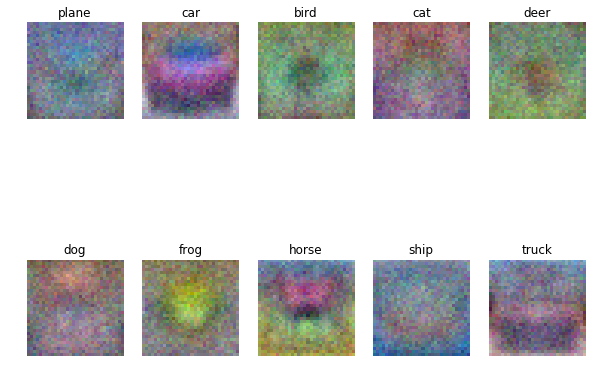

In [55]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])